##### The creation of a hybrid anomaly detection model starts by preparing the dataset. Then, choose important features and divide the data for training and testing. Utilize a sparse autoencoder to simplify the input space. Normalize features with feature scaling. Next, SVM will be used for precise classification, and Isolation Forest will be used for outlier detection. Assess model performance with various metrics. This method combines different models for efficient anomaly detection.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.layers import Input, Dense
from keras.models import Model

Epoch 1/50
1222/1222 [==============================] - 2s 1ms/step - loss: -58756.8516 - val_loss: -152636.0938
Epoch 2/50
1222/1222 [==============================] - 1s 1ms/step - loss: -323842.9688 - val_loss: -516554.0312
Epoch 3/50
1222/1222 [==============================] - 1s 1ms/step - loss: -787865.7500 - val_loss: -1051334.0000
Epoch 4/50
1222/1222 [==============================] - 1s 1ms/step - loss: -1403519.1250 - val_loss: -1723110.1250
Epoch 5/50
1222/1222 [==============================] - 1s 1ms/step - loss: -2150727.0000 - val_loss: -2511782.2500
Epoch 6/50
1222/1222 [==============================] - 1s 1ms/step - loss: -3022284.7500 - val_loss: -3427491.7500
Epoch 7/50
1222/1222 [==============================] - 2s 1ms/step - loss: -4016503.2500 - val_loss: -4464835.0000
Epoch 8/50
1222/1222 [==============================] - 1s 1ms/step - loss: -5140015.0000 - val_loss: -5625824.0000
Epoch 9/50
1222/1222 [==============================] - 1s 1ms/step - loss: -6

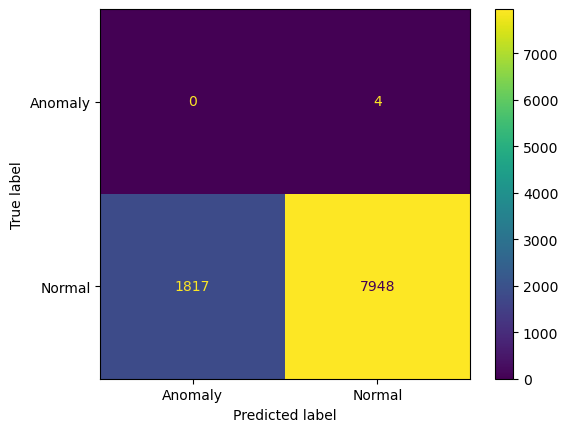

In [10]:

def complete_anomaly_detection_system():
    
    # Load data from a CSV file   
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 20000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()

    data.dropna(axis=0, inplace=True)
    
    # Sparse Autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 5  # You can adjust the encoding dimension as needed
    input_data = Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_data)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder_model = Model(input_data, decoded)
    autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder_model.fit(X_selected, X_selected, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    # Get the encoded representation of the data
    encoded_data = autoencoder_model.predict(X_selected)
    
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=0.2, random_state=42)
    
    # Scale the features to [0, 1]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)

    
    # Train SVM on the encoded data
    svm = SVC(kernel='rbf', gamma='auto', class_weight='balanced', random_state=42)
    svm.fit(X_scaled, y_train)
    
    # Predict with SVM
    svm_predictions_train = svm.predict(X_scaled)
    
    # Filter only rows SVM detected as normal
    normal_indices_train = svm_predictions_train == 1
    X_train_normal = X_scaled[normal_indices_train]
    
    # Train Isolation Forest on the filtered normal data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_normal)
    
    # Predict on the test data with Isolation Forest
    if_predictions = iso_forest.predict(X_test)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Convert -1, 1 to 0, 1
    
    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)
    recall = recall_score(y_test, if_predictions, pos_label=0)
    f1 = f1_score(y_test, if_predictions, pos_label=0)
    
    print(classification_report(y_test, if_predictions))
    

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage
complete_anomaly_detection_system()